# **1. Introduction**

In [ ]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sb
import torch
from torchsummary import summary
from torchvision import models
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models.vision_transformer import vit_b_16, ViT_B_16_Weights
from torchvision.utils import make_grid
from torch.autograd import Variable
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support
import shutil
import warnings
warnings.filterwarnings("ignore")

code_dir = '/kaggle/working/'
model_dir = '/kaggle/working/model'
output_dir = '/kaggle/working/output'

if not os.path.exists(code_dir):
    os.mkdir(code_dir)

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

if not os.path.exists(output_dir):
    os.mkdir(output_dir)


In [ ]:
def ViT_model():
    model_vit=vit_b_16(pretrained=True)
    return model_vit

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

In [5]:
criterion = nn.CrossEntropyLoss()

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [7]:
local_archive="/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake"

In [8]:
def train_data_transform(model_type, data_fraction, batch_size):
    if model_type == 'vit':
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

    full_train_dataset = ImageFolder("/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train", transform=transform)
    num_train_data = int(len(full_train_dataset) * data_fraction)
    train_indices = random.sample(range(len(full_train_dataset)), num_train_data)
    train_dataset = torch.utils.data.Subset(full_train_dataset, train_indices)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader

In [9]:
def val_data_transform(model_type, data_fraction, batch_size):
    if model_type == 'vit':
        transform = ViT_B_16_Weights.IMAGENET1K_V1.transforms()
    
    full_valid_dataset = ImageFolder("/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid", transform=transform)

    num_valid_data = int(len(full_valid_dataset) * data_fraction)
    random.seed(42)  # For reproducibility
    valid_indices = random.sample(range(len(full_valid_dataset)), num_valid_data)

    valid_dataset = torch.utils.data.Subset(full_valid_dataset, valid_indices)

    val_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    return val_dataloader

In [10]:
def test_data_transform(model_type, data_fraction, batch_size):     
    if model_type == 'vit':
        transform = ViT_B_16_Weights.IMAGENET1K_V1.transforms()
    
    full_test_dataset = ImageFolder("/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test", transform=transform)

    num_test_data = int(len(full_test_dataset) * data_fraction)

    test_indices = random.sample(range(len(full_test_dataset)), num_test_data)

    test_dataset = torch.utils.data.Subset(full_test_dataset, test_indices)

    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return test_dataloader

In [11]:
def train(model_type, exp, model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, num_epochs, ft=True, patience=2):
    best_f1 = 0
    trigger_times = 0
    all_metrics = []  # Store metrics per epoch

    for epoch in range(num_epochs):  # This is the epoch loop
        train_loss, train_accuracy, train_f1 = 0.0, 0.0, 0.0
        val_loss, val_accuracy, val_f1 = 0.0, 0.0, 0.0

        # === FREEZE / UNFREEZE ===
        if not ft:
            for param in model.parameters():
                param.requires_grad = False
            if hasattr(model, 'head'):
                for param in model.head.parameters():
                    param.requires_grad = True
            elif hasattr(model, 'classifier'):
                for param in model.classifier.parameters():
                    param.requires_grad = True
            else:
                raise ValueError("Model head not found.")
        else:
            for param in model.parameters():
                param.requires_grad = True

        # === TRAINING ===
        model.train()
        running_loss = 0.0
        y_true_train, y_pred_train = [], []

        loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch [{epoch+1}/{num_epochs}]")

        for batch_idx, (images, labels) in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = outputs.argmax(dim=1)
            y_true_train.extend(labels.cpu().tolist())
            y_pred_train.extend(predicted.cpu().tolist())
            loop.set_postfix(loss=loss.item())

        if scheduler:
            scheduler.step()

        train_loss = running_loss / len(train_dataloader.dataset)
        train_accuracy = accuracy_score(y_true_train, y_pred_train)
        _, _, train_f1, _ = precision_recall_fscore_support(y_true_train, y_pred_train, average='macro', zero_division=0)
        print(f"Train Loss: {train_loss:.6f} | Acc: {train_accuracy*100:.2f}% | F1: {train_f1:.6f}")

        # === VALIDATION ===
        model.eval()
        y_true_val, y_pred_val = [], []
        val_running_loss = 0.0

        with torch.no_grad():
            for images, labels in val_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                predicted = outputs.argmax(dim=1)
                y_true_val.extend(labels.cpu().tolist())
                y_pred_val.extend(predicted.cpu().tolist())

        val_loss = val_running_loss / len(val_dataloader.dataset)
        val_accuracy = accuracy_score(y_true_val, y_pred_val)
        _, _, val_f1, _ = precision_recall_fscore_support(y_true_val, y_pred_val, average='macro', zero_division=0)

        print(f"Val Loss: {val_loss:.6f} | Acc: {val_accuracy*100:.2f}% | F1: {val_f1:.6f}")

        # === EARLY STOPPING ===
        if val_f1 > best_f1:
            best_f1 = val_f1
            trigger_times = 0
            best_model_path = os.path.join(model_dir, f'best_model_{model_type}_exp_{exp}.pth')
            torch.save(model.state_dict(), best_model_path)
            print(f"✅ Model saved at {best_model_path}")
        else:
            trigger_times += 1
            print(f"⚠️ No improvement. Patience: {trigger_times}/{patience}")
            if trigger_times >= patience:
                print("⛔ Early stopping triggered.")
                break

        # Store metrics per epoch
        all_metrics.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'train_f1': train_f1,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'val_f1': val_f1
        })

    # Save metrics to CSV after the last epoch
    df = pd.DataFrame(all_metrics)
    df.to_csv('metrics.csv', index=False)

    return train_loss, train_accuracy, train_f1, val_loss, val_accuracy, val_f1


In [12]:
import torch.nn.functional as F
def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    #y_pred_probs = []  # To store predicted probabilities

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Get raw logits from the model

            # Compute loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Get predicted class (argmax for classification)
            predicted = outputs.argmax(dim=1)

            # Append to y_true and y_pred
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(predicted.cpu().tolist())

            # Update correct and total for accuracy calculation
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
              
    test_loss = running_loss / len(list(dataloader.dataset))
    test_accuracy = accuracy_score(y_true, y_pred)
    precision, recall, test_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro',zero_division=0)

    print(f"Test Loss: {test_loss:.6f} | Test Accuracy: {(test_accuracy * 100):.2f}% | Test F1-Score: {test_f1:.6f}")
    return test_loss, test_accuracy, test_f1, y_pred, y_true

# Orginal training process

In [13]:
def train_model(model_type, data_fraction, num_epochs=10, batch_size=32, learning_rate=0.0001):

    # Initialize metrics
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []
    val_f1 = []

    num_classes = 2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Dataset info for logging
    num_train_data = int(100000 * data_fraction)
    num_valid_data = int(20000 * data_fraction)
    print(f"Training samples: {num_train_data}")
    print(f"Validation samples: {num_valid_data}")
    print("====================Starting==================================")

    # Load data
    train_dataloader = train_data_transform(model_type, data_fraction, batch_size)
    val_dataloader = val_data_transform(model_type, data_fraction, batch_size)
    
    # === MODEL SETUP ===
    if model_type == 'vit':
        model = ViT_model()
        #uncomment if you are using all layers freezing technique
        #model.heads=nn.Linear(768,2)

        #comment if you are using freezing technique
        model.head = nn.Sequential(
            nn.Linear(768, 512),   # First linear layer
            nn.ReLU(),
            nn.Dropout(p=0.3),     # Dropout with a rate of 0.3
            nn.Linear(512, num_classes)  # Final classification layer
        )
    else:
        raise ValueError("Unsupported model_type. Extend logic for other models.")

    model = model.to(device)
    num=10
    # === LOSS, OPTIMIZER, SCHEDULER ===
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # === TRAINING ===
    print(f"Experiment: {model_type.upper()} with Fine-Tuning")

    train_loss, train_accuracy, train_f1, val_loss, val_accuracy, val_f1 = train(
        model_type=model_type,
        exp=2,
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        num_epochs=num_epochs,
        ft=True, patience=2)

    return train_loss, train_accuracy, train_f1, val_loss, val_accuracy, val_f1


# Orginal training process

In [ ]:
#history = run_fyp_scenario('vit',0.1, num_epochs=10, batch_size=16, learning_rate=0.0001)

In [ ]:
#mean_df = df.groupby(['Model', 'Experiment']).mean()
#print(mean_df)

# Training Starts

In [14]:
train_loss, train_accuracy, train_f1, val_loss, val_accuracy, val_f1 = train_model('vit',1, num_epochs=10, batch_size=32, learning_rate=1e-4)

Using device: cuda
Training samples: 100000
Validation samples: 20000
====================Starting==================================


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 232MB/s] 


Experiment: VIT with Fine-Tuning


Epoch [1/10]: 100%|██████████| 3125/3125 [1:15:06<00:00,  1.44s/it, loss=0.13]  

Train Loss: 0.006780 | Acc: 90.79% | F1: 0.060535


Val Loss: 0.003855 | Acc: 95.06% | F1: 0.950551
✅ Model saved at /kaggle/working/model/best_model_vit_exp_2.pth


Epoch [2/10]: 100%|██████████| 3125/3125 [1:10:34<00:00,  1.35s/it, loss=0.0208] 

Train Loss: 0.003338 | Acc: 95.86% | F1: 0.958630


Val Loss: 0.001848 | Acc: 97.88% | F1: 0.978749
✅ Model saved at /kaggle/working/model/best_model_vit_exp_2.pth


Epoch [3/10]: 100%|██████████| 3125/3125 [1:12:16<00:00,  1.39s/it, loss=0.0232]  

Train Loss: 0.002470 | Acc: 97.02% | F1: 0.970160


Val Loss: 0.004317 | Acc: 95.00% | F1: 0.949944
⚠️ No improvement. Patience: 1/2


Epoch [4/10]: 100%|██████████| 3125/3125 [1:10:59<00:00,  1.36s/it, loss=0.0111]  

Train Loss: 0.001776 | Acc: 97.85% | F1: 0.978490


Val Loss: 0.001447 | Acc: 98.38% | F1: 0.983800
✅ Model saved at /kaggle/working/model/best_model_vit_exp_2.pth


Epoch [5/10]: 100%|██████████| 3125/3125 [1:11:20<00:00,  1.37s/it, loss=0.0241]  

Train Loss: 0.001211 | Acc: 98.57% | F1: 0.985680


Val Loss: 0.000886 | Acc: 98.95% | F1: 0.989500
✅ Model saved at /kaggle/working/model/best_model_vit_exp_2.pth


Epoch [6/10]: 100%|██████████| 3125/3125 [1:11:40<00:00,  1.38s/it, loss=0.00951] 

Train Loss: 0.000773 | Acc: 99.09% | F1: 0.990870


Val Loss: 0.001335 | Acc: 98.43% | F1: 0.984347
⚠️ No improvement. Patience: 1/2


Epoch [7/10]: 100%|██████████| 3125/3125 [1:10:31<00:00,  1.35s/it, loss=0.00131] 

Train Loss: 0.000443 | Acc: 99.48% | F1: 0.994820


Val Loss: 0.001566 | Acc: 98.21% | F1: 0.982095
⚠️ No improvement. Patience: 2/2
⛔ Early stopping triggered.


## Train Val data

In [15]:
values = [train_loss, train_accuracy, train_f1, val_loss, val_accuracy, val_f1]
values_percentage = [str(round(value * 100, 2)) + '%' for value in values]
df_fyp = pd.DataFrame({
    'Metric': ['Train Loss', 'Train Accuracy', 'Train F1', 
               'Validation Loss', 'Validation Accuracy', 'Validation F1'],
    'Value': values_percentage
})

In [16]:
df_fyp

,Metric,Value
0,Train Loss,0.04%
1,Train Accuracy,99.48%
2,Train F1,99.48%
3,Validation Loss,0.16%
4,Validation Accuracy,98.21%
5,Validation F1,98.21%


# Testing

In [17]:
test_dataloader = test_data_transform('vit', 1, 32)

In [20]:

# === Setup ===
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NUM_CLASSES = 2  # Update to match your model

# Load the model architecture and weights
model = ViT_model()
model.head = nn.Sequential(
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(512, NUM_CLASSES)
)

# Load saved weights
model.load_state_dict(torch.load('/kaggle/working/model/best_model_vit_exp_2.pth', map_location=DEVICE))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# === Run test ===
test_loss, test_accuracy, test_f1, y_pred, y_true = test(model, test_dataloader, criterion, DEVICE)

cuda
Test Loss: 0.000971 | Test Accuracy: 98.86% | Test F1-Score: 0.988600


## Test Data

In [21]:
values = [test_loss, test_accuracy, test_f1]
values_percentage = [str(round(value * 100, 2)) + '%' for value in values]
df_test = pd.DataFrame({
    'Metric': ['Test Loss', 'Test Accuracy', 'Test F1'],
    'Value': values_percentage
})
df_test

,Metric,Value
0,Test Loss,0.1%
1,Test Accuracy,98.86%
2,Test F1,98.86%


In [30]:
df = pd.read_csv('/kaggle/working/metrics.csv')
df

,epoch,train_loss,train_accuracy,train_f1,val_loss,val_accuracy,val_f1
0,1,0.006780,0.90786,0.060535,0.003855,0.95060,0.950551
1,2,0.003338,0.95863,0.958630,0.001848,0.97875,0.978749
2,3,0.002470,0.97016,0.970160,0.004317,0.95005,0.949944
3,4,0.001776,0.97849,0.978490,0.001447,0.98380,0.983800
4,5,0.001211,0.98568,0.985680,0.000886,0.98950,0.989500
5,6,0.000773,0.99087,0.990870,0.001335,0.98435,0.984347


In [31]:
save_dir = '/kaggle/working/output'

# Plotting Code

In [35]:
import os
import matplotlib.pyplot as plt

def plot_acc_graphs(df, save_dir=None):
    fig, ax = plt.subplots(figsize=(8, 5))

    ax.plot(df['epoch'], df['train_accuracy'], marker='o', label='Train Accuracy')
    ax.plot(df['epoch'], df['val_accuracy'], marker='o', linestyle='--', label='Validation Accuracy')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training vs Validation Accuracy')
    ax.legend()
    ax.set_ylim(bottom=0.0, top=1.0)
    plt.grid(True)
    plt.tight_layout()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plot_path = os.path.join(save_dir, 'acc_plot.png')
        plt.savefig(plot_path, dpi=500)
        print(f"Plot saved to {plot_path}")

    plt.show()


def plot_loss_graphs(df, save_dir=None):
    fig, ax = plt.subplots(figsize=(8, 5))

    ax.plot(df['epoch'], df['train_loss'], marker='o', label='Train Loss')
    ax.plot(df['epoch'], df['val_loss'], marker='o', linestyle='--', label='Validation Loss')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training vs Validation Loss')
    ax.legend()
    ax.set_ylim(bottom=0.0)
    plt.grid(True)
    plt.tight_layout()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plot_path = os.path.join(save_dir, 'loss_plot.png')
        plt.savefig(plot_path, dpi=500)
        print(f"Plot saved to {plot_path}")

    plt.show()


Plot saved to /kaggle/working/output/acc_plot.png


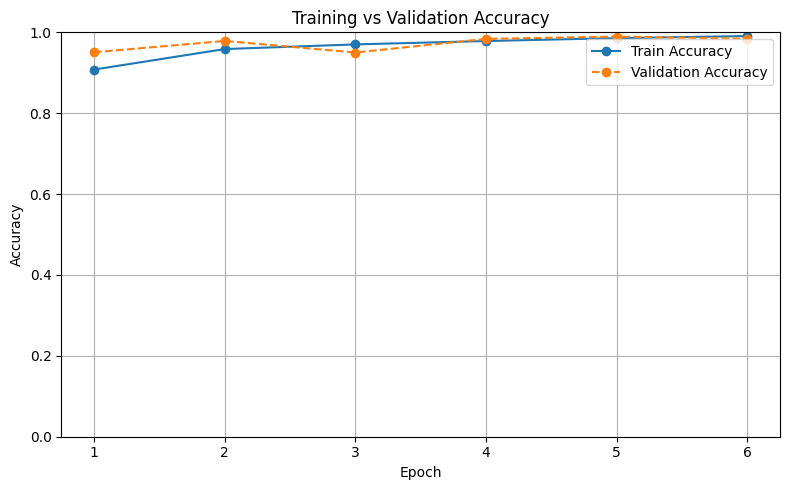

Plot saved to /kaggle/working/output/loss_plot.png


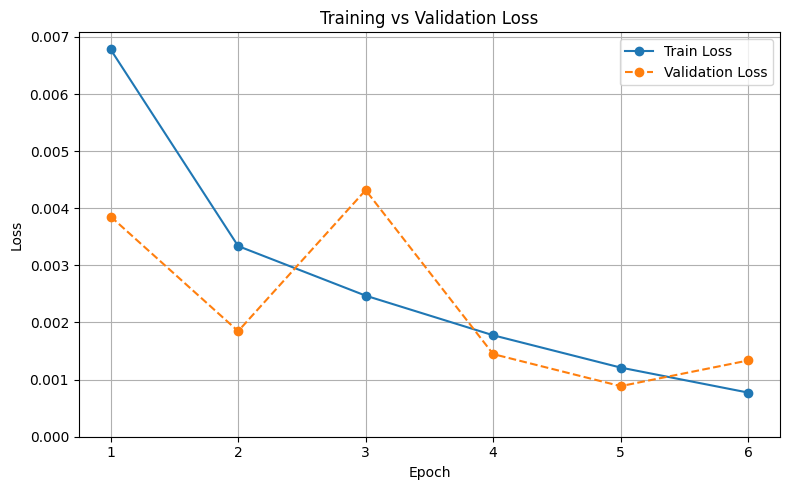

In [36]:
plot_acc_graphs(df, save_dir = "/kaggle/working/output")
plot_loss_graphs(df, save_dir = "/kaggle/working/output")

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, epoch):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'ViT Model Confusion Matrix (Epoch {epoch + 1})')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = conf_matrix.max() / 2.0
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(j, i, conf_matrix[i, j], horizontalalignment="center", color="white" if conf_matrix[i, j] > thresh else "black")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.tight_layout()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plot_path = os.path.join(save_dir, 'confusionMatrix.png')
        plt.savefig(plot_path, dpi = 500)
        print(f"Plot saved to {plot_path}")
        
    plt.show()

Plot saved to /kaggle/working/output/confusionMatrix.png


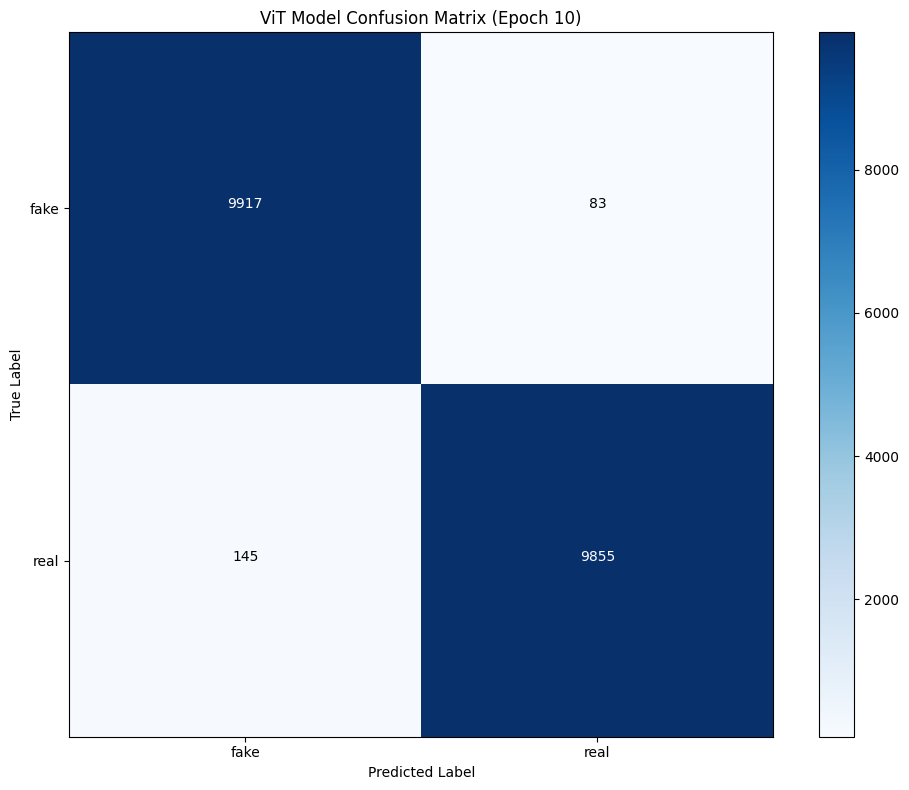

In [38]:
class_names = ['fake', 'real']
num_epochs = 10
#unique_labels = np.unique(val_y_true)
#class_names = [str(label) for label in unique_labels]
plot_confusion_matrix(y_true, y_pred, class_names, num_epochs - 1)

In [39]:
from sklearn.metrics import classification_report
# Print training metrics
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")
print(f"Training F1 Score: {train_f1}")

# Print testing metrics
print(f"Testing Loss: {test_loss}")
print(f"Testing Accuracy: {test_accuracy}")
print(f"Testing F1 Score: {test_f1}")

# Generate classification report
report = classification_report(y_true, y_pred, target_names=['fake', 'real'])

print("")
print("Classification Report:")
print(report)

Training Loss: 0.000443248634348829
Training Accuracy: 0.99482
Training F1 Score: 0.994819999981352
Testing Loss: 0.0009713295085508434
Testing Accuracy: 0.9886
Testing F1 Score: 0.9885998904449473

Classification Report:
              precision    recall  f1-score   support

        fake       0.99      0.99      0.99     10000
        real       0.99      0.99      0.99     10000

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



Plot saved to /kaggle/working/output/aucroc_plot.png


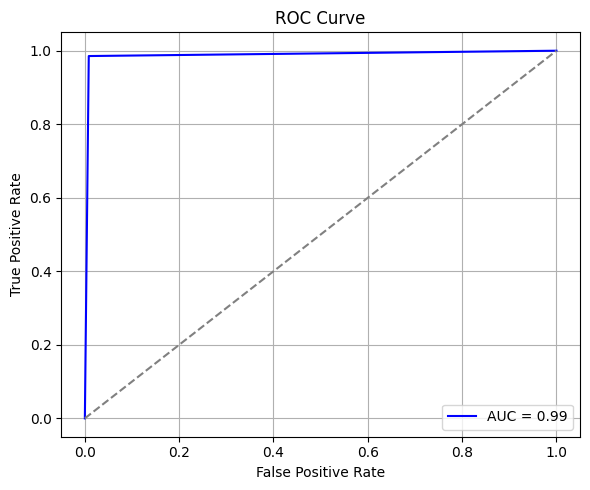

In [40]:
from sklearn.metrics import roc_curve, auc
def plot_auc_roc(y_true, y_pred, save_dir=None):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plot_path = os.path.join(save_dir, 'aucroc_plot.png')
        plt.savefig(plot_path, dpi = 500)
        print(f"Plot saved to {plot_path}")
    plt.show()

plot_auc_roc(y_true, y_pred, save_dir = "/kaggle/working/output")

In [41]:
df.to_csv('Metrics.csv', index = False)
df_test.to_csv('Test_Metrics.csv', index = False)

In [42]:
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, 
    log_loss, brier_score_loss, cohen_kappa_score
)
import numpy as np

def evaluate_metrics(y_true, y_pred_probs, threshold=0.5):
    y_pred_probs = np.array(y_pred_probs)
    y_true = np.array(y_true)

    y_pred = (y_pred_probs >= threshold).astype(int)

    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_pred_probs),
        'Log Loss': log_loss(y_true, y_pred_probs),
        'Brier Score': brier_score_loss(y_true, y_pred_probs),
        'Cohen\'s Kappa': cohen_kappa_score(y_true, y_pred),
    }

    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    return metrics

evaluate_metrics(y_true, y_pred, threshold=0.5)

Accuracy: 0.9886
F1 Score: 0.9886
ROC AUC: 0.9886
Log Loss: 0.4109
Brier Score: 0.0114
Cohen's Kappa: 0.9772


{'Accuracy': 0.9886,
 'F1 Score': 0.9885645501053266,
 'ROC AUC': 0.9886,
 'Log Loss': 0.41089764863593575,
 'Brier Score': 0.0114,
 "Cohen's Kappa": 0.9772}

Plot saved to /kaggle/working/output/reliable_plot.png


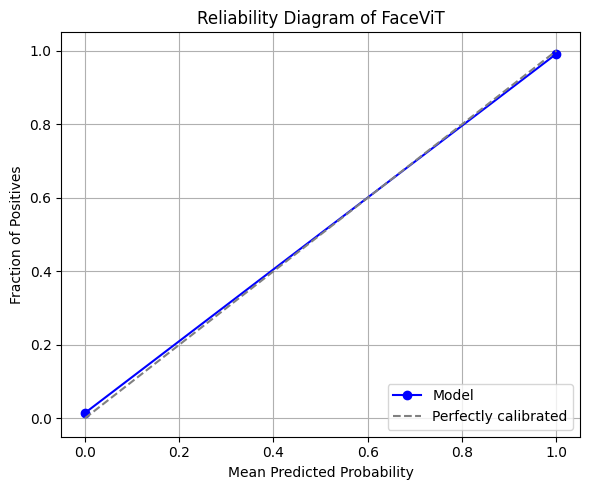

In [43]:
from sklearn.calibration import calibration_curve

def plot_reliability_diagram(y_true, y_pred_probs, n_bins=10, save_dir=None):
    # Compute the calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_pred_probs, n_bins=n_bins)

    # Plot the reliability diagram
    plt.figure(figsize=(6, 5))
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Model', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Reliability Diagram of FaceViT')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plot_path = os.path.join(save_dir, 'reliable_plot.png')
        plt.savefig(plot_path, dpi = 500)
        print(f"Plot saved to {plot_path}")
    plt.show()
plot_reliability_diagram(y_true, y_pred, save_dir = "/kaggle/working/output")

# Load the model

In [54]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model architecture and weights
model = ViT_model()
model.head = nn.Sequential(
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(512, NUM_CLASSES)
)

# Load saved weights
model.load_state_dict(torch.load('/kaggle/working/model/best_model_vit_exp_2.pth', map_location=DEVICE))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
model.eval()

cuda


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [55]:
num_param = sum(p.numel() for p in model.parameters())
print(num_param)

86962410


In [68]:
test_variable = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/04IISQZW0V.jpg'
test_variable_ck = os.path.basename(test_variable)
print(test_variable_ck)

04IISQZW0V.jpg


In [70]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the image path and preprocessing transform
image_path = test_variable
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust based on your model's input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Load and transform the image
image = Image.open(image_path).convert('RGB')  # Ensure RGB mode
image = transform(image)
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to GPU

# Load your model and send it to the same device
model = ViT_model()
model.head = nn.Sequential(
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(512, NUM_CLASSES)
)

# Load saved weights
model.load_state_dict(torch.load('/kaggle/working/model/best_model_vit_exp_2.pth', map_location = device))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
model.eval()

# Forward pass to get the attention map (assuming forward returns it)
with torch.no_grad():
    attention_map = model(image)
    attention_map = attention_map.cpu()

# Print the shape of the attention map
print(f"The shape of the attention map is: {attention_map.shape}")


Using device: cuda
cuda
The shape of the attention map is: torch.Size([1, 1000])


In [71]:
predict_df = pd.read_csv('/kaggle/input/140k-real-and-fake-faces/test.csv')
#predict_df

In [72]:
predict_id = 'test/fake/'+test_variable_ck
Actual_label = predict_df[predict_df['path'] == predict_id]
#print(Actual_label)
label_str_value = Actual_label['label_str'].values[0]
Actual_label = label_str_value

In [73]:
import os
def get_data():
    return pd.read_csv('/kaggle/input/140k-real-and-fake-faces/test.csv')

In [74]:
predict_df=get_data()
predict_df.head()

,Unnamed: 0,original_path,id,label,label_str,path
0,0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,18233,1,real,test/real/18233.jpg
1,1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,54317,1,real,test/real/54317.jpg
2,2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,40155,1,real,test/real/40155.jpg
3,3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,12875,1,real,test/real/12875.jpg
4,4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,52543,1,real,test/real/52543.jpg


/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/HJZ4059JIK.jpg
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/26B0XBX5AQ.jpg
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/2RY4CGX2QG.jpg
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/05U5CQI8UO.jpg
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/0CHMGS8BF3.jpg
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/KN53E5IGRW.jpg
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/23WQ2PYV9T.jpg
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/R8UI7H3MLM.jpg
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/LIGTR4Z0KC.jpg
Number of correct predictions: 9/9 = 100.0%


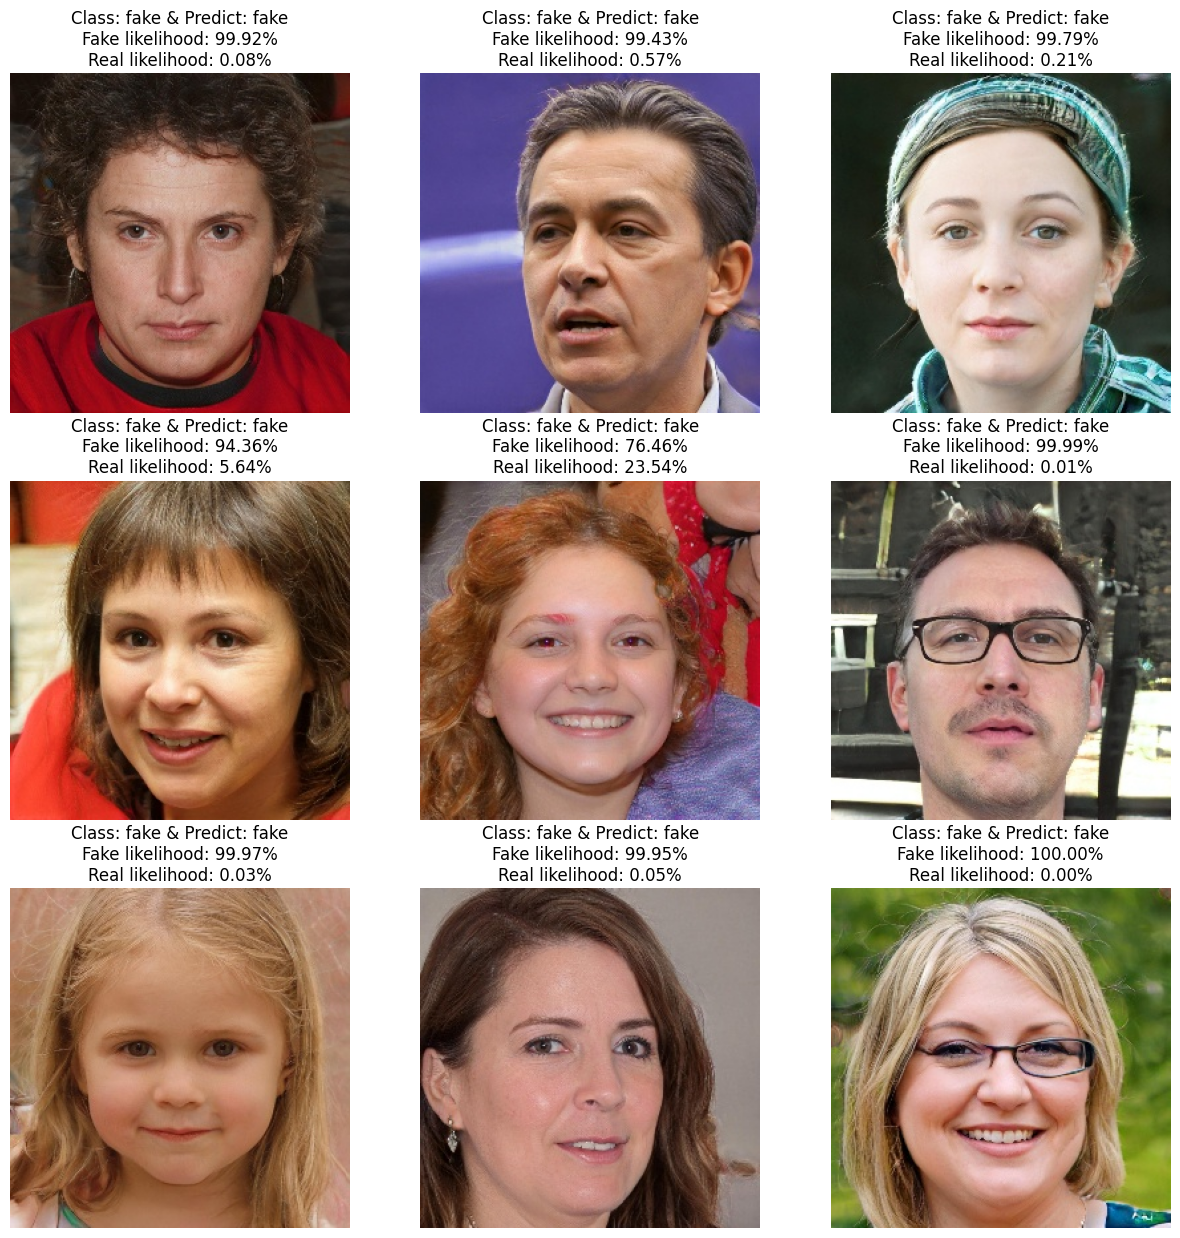

In [89]:
import cv2
import torch.nn.functional as F

# Load the dataframe
predict_df = pd.read_csv('/kaggle/input/140k-real-and-fake-faces/test.csv')

# Define the class names
class_names = ['fake', 'real']

model.to('cuda')
correct_predictions = 0

# Start the prediction loop
random_number = random.randint(0, (len(predict_df)-1))
plt.figure(figsize=(15,15))

for cur, i in enumerate(predict_df.index[random_number:random_number+9]):
    plt.subplot(3, 3, cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/' + predict_df.loc[i, 'path']
    #print('Start predict')
    #print('--------------------------------------------------------------------------')
    #print(predict_df.loc[i, 'path'])
    print(image_path)
    image_bgr = cv2.imread(image_path)
    if image_bgr is not None:
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)

        # Open the image and apply the transform
        image = Image.open(image_path)
        image = transform(image)
        image = image.unsqueeze(0).to('cuda')

        num_predictions = 10
        probabilities_list = []
        for _ in range(num_predictions):
            output = model(image)
            probabilities = F.softmax(output, dim=1)
            probabilities_list.append(probabilities.tolist()[0])

        # Average the probabilities
        avg_probabilities = np.mean(probabilities_list, axis=0)
        #print('Check 1: Probabilities: ' + str(probabilities))
        fake_probability = probabilities_list[0][0]
        real_probability = probabilities_list[0][1]
        fake_probability_percentage = fake_probability * 100
        real_probability_percentage = real_probability * 100

        predicted = torch.max(output, 1)
        #print('Check 2: '+ str(predicted))

        predicted_label = class_names[predicted.indices.item()]
        if fake_probability_percentage >= 1:
            predicted_label = 'fake'
        #print('Check 3: '+ str(predicted_label))

        if(predict_df.loc[i,'label']==1):
            classt='real'
        else:
            classt='fake'

        #print('Fake probability: '+ str(round(fake_probability_percentage,2)) + ' %')
        #print('Real probability: '+ str(round(real_probability_percentage,2)) + ' %')
        #print('--------------------------------------------------------------------------')
        #print('End predict')
        #print("")

        if predicted_label == classt:
            correct_predictions += 1

        plt.title(f"Class: {classt} & Predict: {predicted_label}\nFake likelihood: {fake_probability_percentage:.2f}%\nReal likelihood: {real_probability_percentage:.2f}%")
    else:
        print(f"Image not found at: {image_path}")
    plt.axis("off")

print(f"Number of correct predictions: {correct_predictions}"+'/'+'9' + ' = ' + str(round(correct_predictions/9*100,2)) + '%')
plt.show()

In [103]:
import torch
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from lime import lime_image
from skimage.segmentation import mark_boundaries


In [105]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT_model().to(device)
model.eval()

# Load ViT-specific transforms
vit_transforms = ViT_B_16_Weights.IMAGENET1K_V1.transforms()

# Load sample test images
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import random

dataset_dir = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test"
test_dataset = ImageFolder(dataset_dir, transform=vit_transforms)
test_subset = Subset(test_dataset, random.sample(range(len(test_dataset)), 10))
test_loader = DataLoader(test_subset, batch_size=1, shuffle=False)

class_names = test_dataset.classes

In [109]:
# Helper: Apply colormap overlay on original image
def overlay_heatmap_on_image(original_img, heatmap, alpha=0.5):
    colored_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    base = np.array(original_img.resize((224, 224)))
    overlay = cv2.addWeighted(base, 1 - alpha, colored_heatmap, alpha, 0)
    return overlay

# Generate LIME explanation image with positive + negative contributions
def get_lime_image(img_pil, img_path):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        np.array(img_pil),
        predict_fn,  # user-defined prediction wrapper
        top_labels=1,
        hide_color=0,
        num_features=10,
        num_samples=1000
    )
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,  # include both positive and negative
        num_features=10,
        hide_rest=False
    )
    return mark_boundaries(temp / 255.0, mask)

# Grad-CAM function for ViT
def generate_gradcam_vit(input_tensor, model):
    """
    Generate Grad-CAM for Vision Transformer (ViT) model.
    Args:
        input_tensor: Input image tensor.
        model: Pretrained ViT model.
    Returns:
        Grad-CAM heatmap as a numpy array.
    """
    model.eval()
    # Grad-CAM
    cam = generate_gradcam_vit(img_tensor, model)
    # Forward pass to get the logits
    logits = model(input_tensor)

    # Get the index of the predicted class
    predicted_class = logits.argmax(dim=-1).item()

    # Backward pass to get the gradients of the predicted class w.r.t. the embeddings
    model.zero_grad()
    logits[0, predicted_class].backward()

    # Extract the gradients and embeddings
    gradients = model.get_last_selfattention().gradients  # Replace with actual gradient extraction
    embeddings = model.get_last_selfattention().embeddings  # Replace with actual embedding extraction

    # Compute Grad-CAM
    weights = gradients.mean(dim=(2, 3), keepdim=True)  # Global average pooling
    gradcam = (weights * embeddings).sum(dim=1).squeeze()  # Weighted sum of embeddings
    gradcam = gradcam.cpu().detach().numpy()

    # Normalize Grad-CAM
    gradcam = np.maximum(gradcam, 0)  # ReLU
    gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min())  # Normalize to [0, 1]
    gradcam = (gradcam * 255).astype(np.uint8)  # Scale to [0, 255]

    return gradcam

# Main function to display original + Grad-CAM + LIME for selected images
def plot_gradcam_lime(indices, class_name, samples_per_class=10):
    fig, axes = plt.subplots(samples_per_class, 3, figsize=(15, 3 * samples_per_class))
    fig.suptitle(f"{class_name.upper()} Class: Grad-CAM and LIME Visualizations", fontsize=20, color='navy')

    for i, idx in enumerate(indices):
        img_path = test_dataset.samples[idx][0]
        image = Image.open(img_path).convert("RGB")
        img_tensor = vit_transforms(image).to(device)
        original_img = image.resize((224, 224))

        # Grad-CAM
        cam = generate_gradcam_vit(img_tensor, model)
        cam_resized = cv2.resize(cam, (224, 224))
        cam_overlay = overlay_heatmap_on_image(original_img, cam_resized)

        # LIME
        lime_img = get_lime_image(original_img, img_path)

        # Plot 3 panels: Original, Grad-CAM, LIME
        titles = ["Original Image", "Grad-CAM Overlay", "LIME Explanation"]
        images = [original_img, cam_overlay, lime_img]

        for j in range(3):
            ax = axes[i, j] if samples_per_class > 1 else axes[j]
            ax.imshow(images[j])
            ax.set_title(titles[j], fontsize=12)
            ax.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Randomly sample 10 real and 10 fake images
real_indices = [i for i, (_, label) in enumerate(test_dataset.samples) if label == 0]
fake_indices = [i for i, (_, label) in enumerate(test_dataset.samples) if label == 1]
random_real = random.sample(real_indices, 10)
random_fake = random.sample(fake_indices, 10)


NameError: name 'img_tensor' is not defined

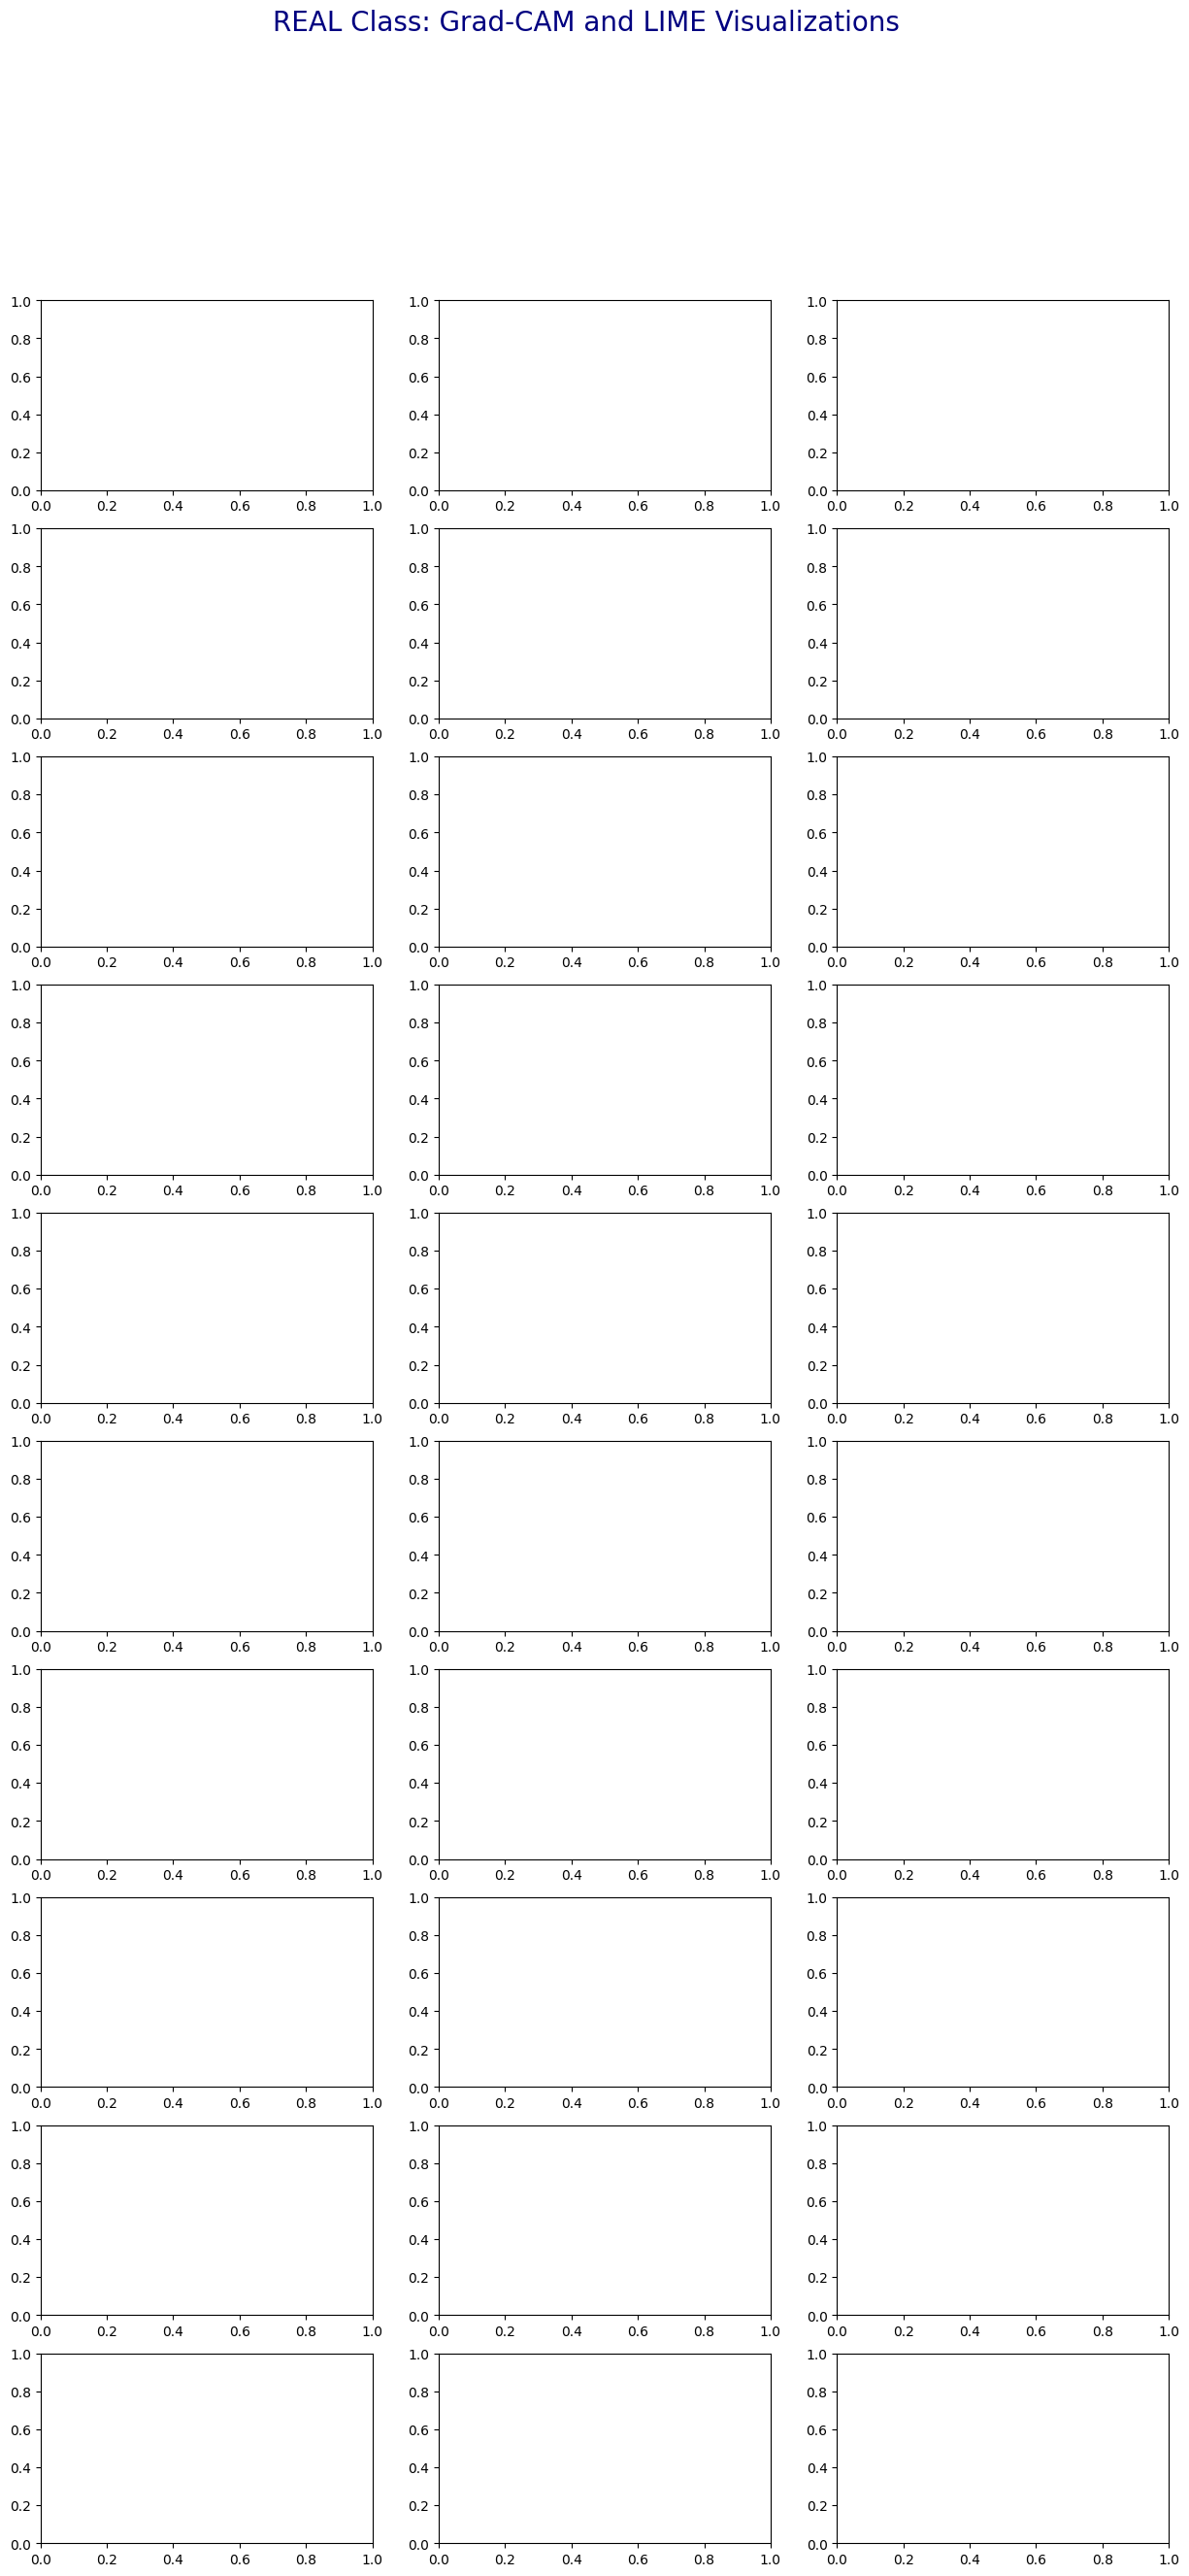

In [110]:
# Run plots
plot_gradcam_lime(random_real, "Real")

NameError: name 'generate_gradcam_vit' is not defined

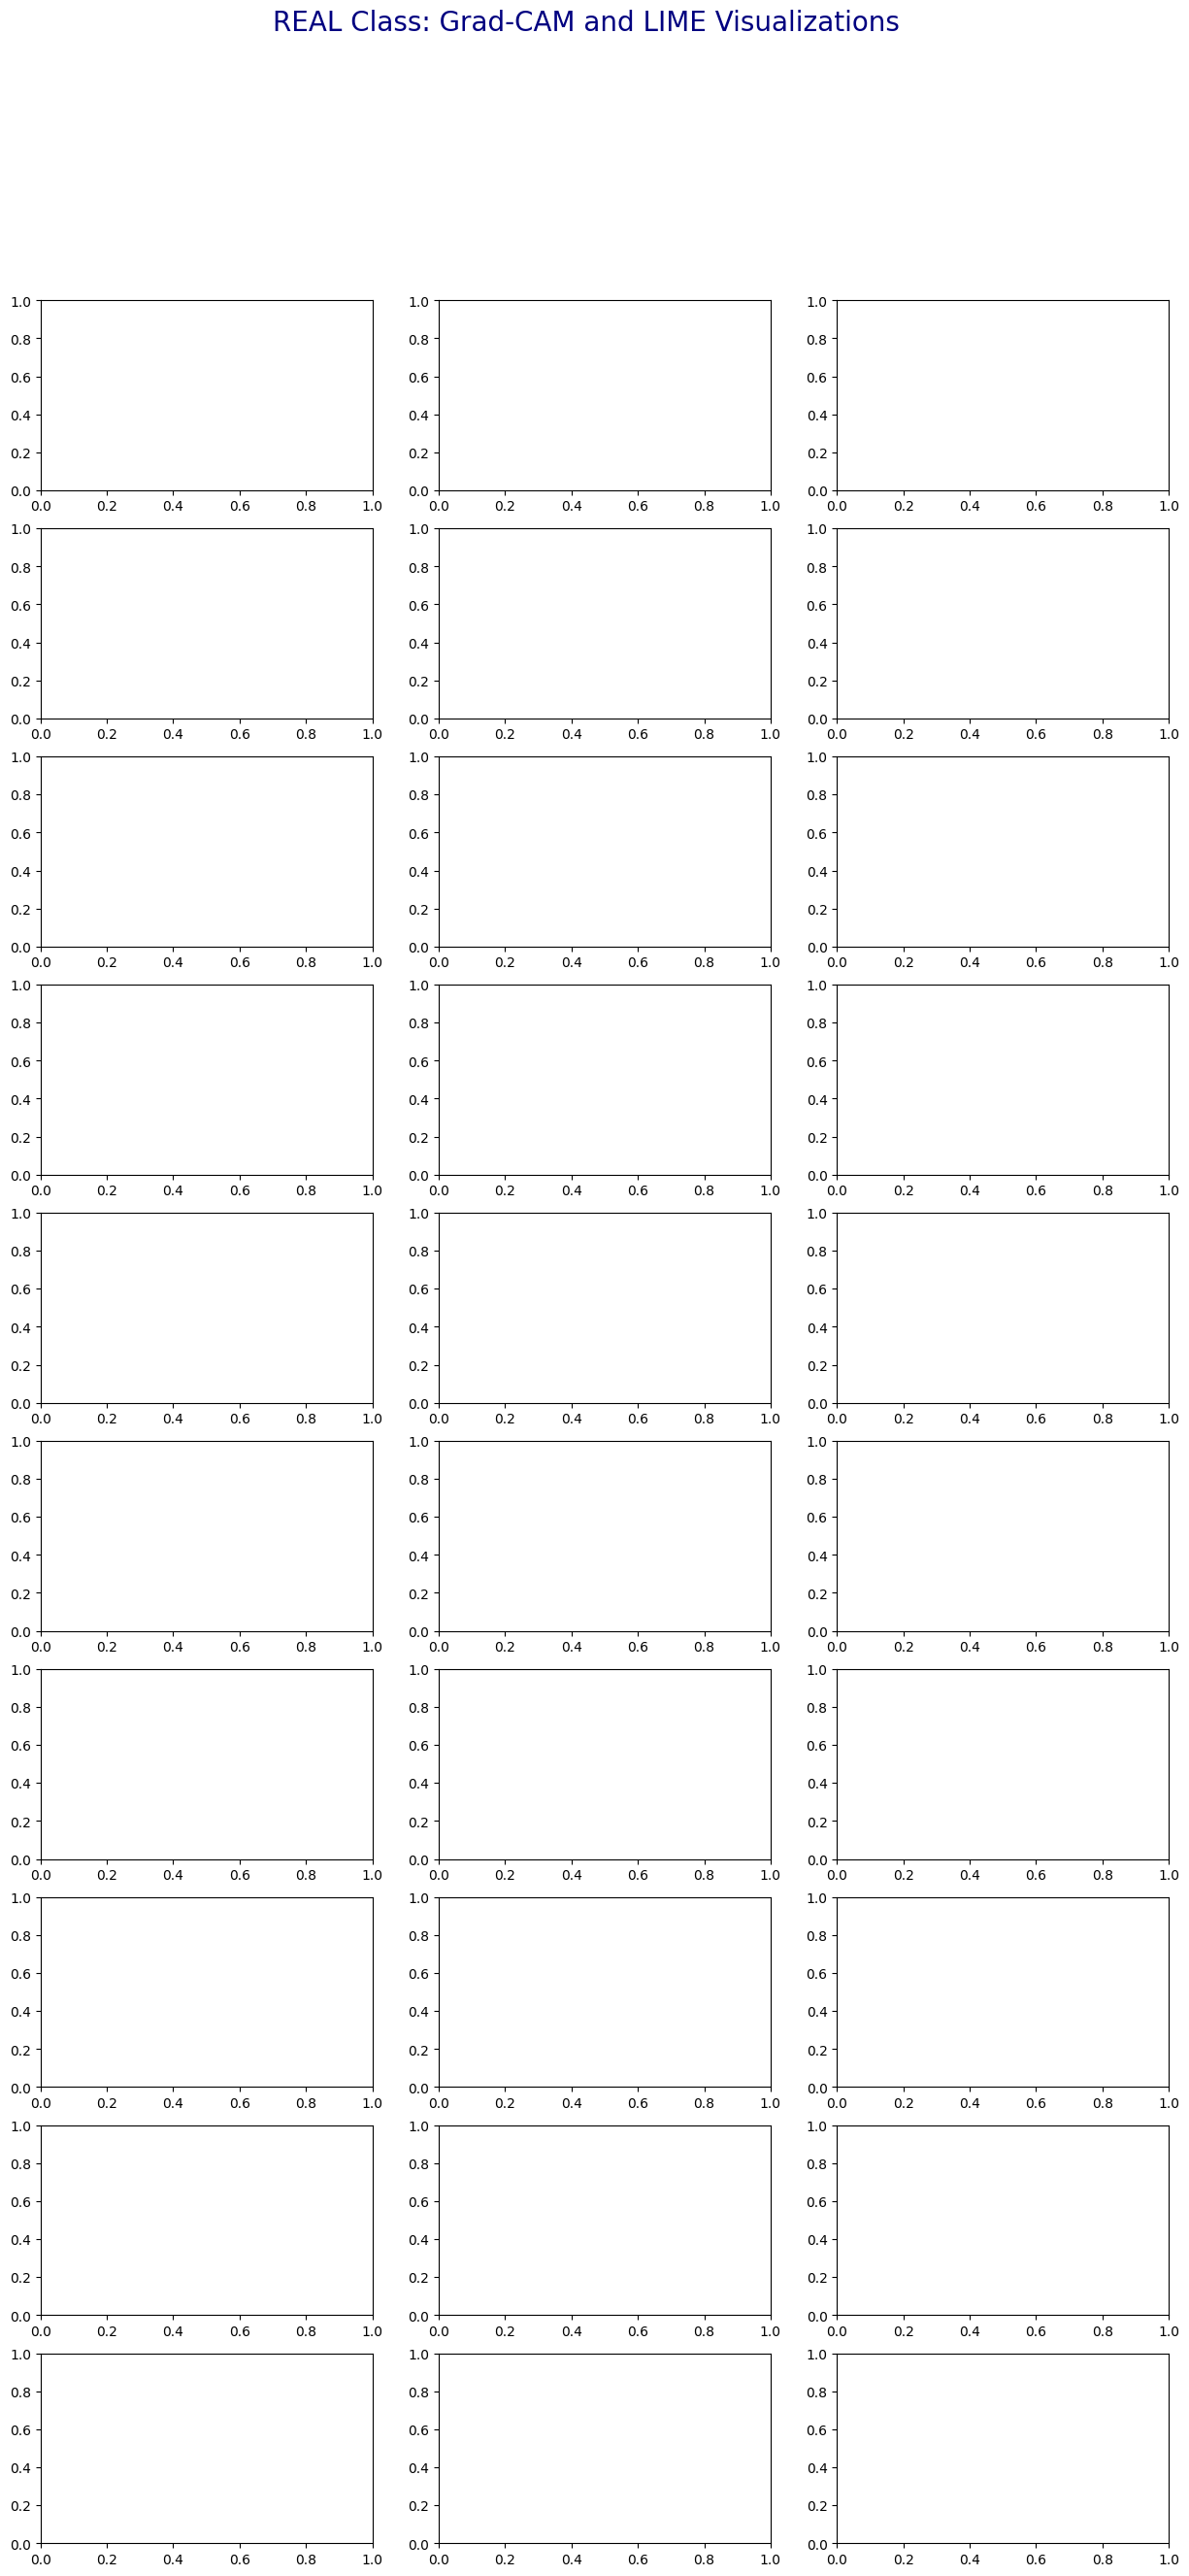

In [97]:
import random
import torchvision.transforms.functional as TF
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Helper: Apply colormap overlay on original image
def overlay_heatmap_on_image(original_img, heatmap, alpha=0.5):
    colored_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    base = np.array(original_img.resize((224, 224)))
    overlay = cv2.addWeighted(base, 1 - alpha, colored_heatmap, alpha, 0)
    return overlay

# Generate LIME explanation image with positive + negative contributions
def get_lime_image(img_pil, img_path):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        np.array(img_pil),
        predict_fn,  # user-defined prediction wrapper
        top_labels=1,
        hide_color=0,
        num_features=10,
        num_samples=1000
    )
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,  # include both positive and negative
        num_features=10,
        hide_rest=False
    )
    return mark_boundaries(temp / 255.0, mask)

# Main function to display original + Grad-CAM + LIME for selected images
def plot_gradcam_lime(indices, class_name, samples_per_class=10):
    fig, axes = plt.subplots(samples_per_class, 3, figsize=(15, 3 * samples_per_class))
    fig.suptitle(f"{class_name.upper()} Class: Grad-CAM and LIME Visualizations", fontsize=20, color='navy')

    for i, idx in enumerate(indices):
        img_path = test_dataset.samples[idx][0]
        image = Image.open(img_path).convert("RGB")
        img_tensor = vit_transforms(image).to(device)
        original_img = image.resize((224, 224))

        # Grad-CAM
        cam = generate_gradcam_vit(img_tensor)
        cam_resized = cv2.resize(cam, (224, 224))
        cam_overlay = overlay_heatmap_on_image(original_img, cam_resized)

        # LIME
        lime_img = get_lime_image(original_img, img_path)

        # Plot 3 panels: Original, Grad-CAM, LIME
        titles = ["Original Image", "Grad-CAM Overlay", "LIME Explanation"]
        images = [original_img, cam_overlay, lime_img]

        for j in range(3):
            ax = axes[i, j] if samples_per_class > 1 else axes[j]
            ax.imshow(images[j])
            ax.set_title(titles[j], fontsize=12)
            ax.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Randomly sample 10 real and 10 fake images
real_indices = [i for i, (_, label) in enumerate(test_dataset.samples) if label == 0]
fake_indices = [i for i, (_, label) in enumerate(test_dataset.samples) if label == 1]

random_real = random.sample(real_indices, 10)
random_fake = random.sample(fake_indices, 10)

# Run plots
plot_gradcam_lime(random_real, "Real")
plot_gradcam_lime(random_fake, "Fake")


NameError: name 'generate_gradcam_vit' is not defined

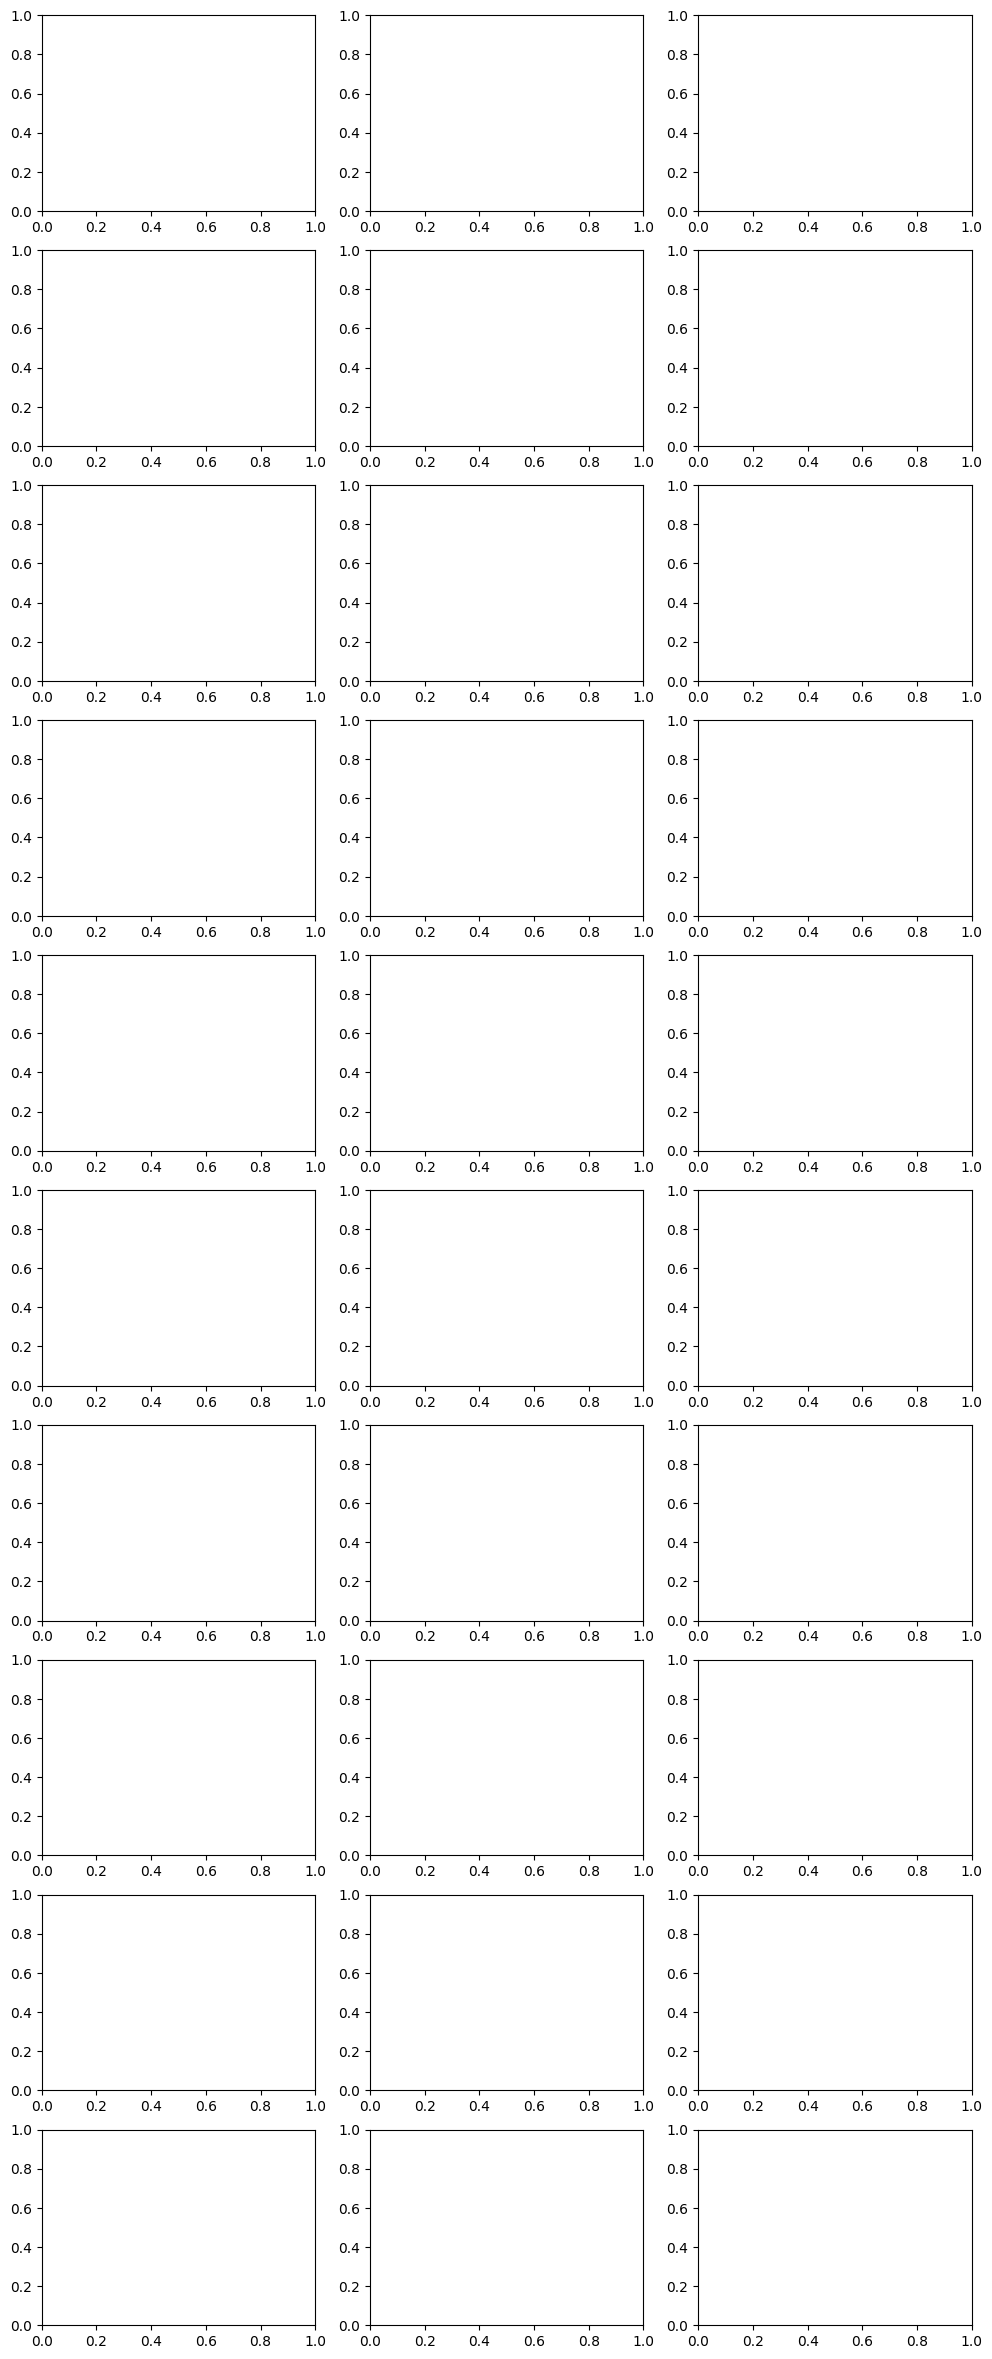

In [98]:
import random
import torchvision.transforms.functional as TF
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Helper: Overlay heatmap on image
def overlay_cam_on_image(original_img, cam, alpha=0.5):
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    original_np = np.array(original_img.resize((224, 224)))
    overlay = cv2.addWeighted(original_np, 1 - alpha, heatmap, alpha, 0)
    return overlay

# Sample 10 real and 10 fake indices
real_indices = [i for i, (_, label) in enumerate(test_dataset.samples) if label == 0]
fake_indices = [i for i, (_, label) in enumerate(test_dataset.samples) if label == 1]

random_real = random.sample(real_indices, 10)
random_fake = random.sample(fake_indices, 10)

# Function to plot results
def plot_gradcam_lime(indices, class_name):
    fig, axes = plt.subplots(10, 3, figsize=(12, 30))
    for i, idx in enumerate(indices):
        img_path = test_dataset.samples[idx][0]
        image = Image.open(img_path).convert("RGB")
        img_tensor = vit_transforms(image)
        original_img = image.resize((224, 224))

        # Grad-CAM
        cam = generate_gradcam_vit(img_tensor)
        cam_resized = cv2.resize(cam, (224, 224))
        cam_overlay = overlay_cam_on_image(original_img, cam_resized)

        # LIME
        lime_img = lime_explanation(img_path)

        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title("Original")
        axes[i, 1].imshow(cam_overlay)
        axes[i, 1].set_title("Grad-CAM")
        axes[i, 2].imshow(lime_img)
        axes[i, 2].set_title("LIME")

        for ax in axes[i]: ax.axis("off")

    plt.suptitle(f"{class_name} Class: Grad-CAM & LIME Explanations", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

# Call the function for both real and fake
plot_gradcam_lime(random_real, "Real")
plot_gradcam_lime(random_fake, "Fake")
